# Optimize A Multi-agent QA pipeline for HotpotQA Workload

In this example, we are building a workflow for [HotpotQA](https://arxiv.org/abs/1809.09600), which requires the agent to retrieve from wiki-2017 documents twice to answer a factorial question.

The implementation is adopted from [dspy](https://github.com/stanfordnlp/dspy?tab=readme-ov-file#5a-dspy-vs-thin-wrappers-for-prompts-openai-api-minichain-basic-templating), including three agents in total:
- **Query agent 0**: generates a search query from the user question.
- **Query agent 1**: refines the search by retrieving additional information based on initial results.
- **Answer agent**: synthesizes the retrieved documents to provide a final answer.

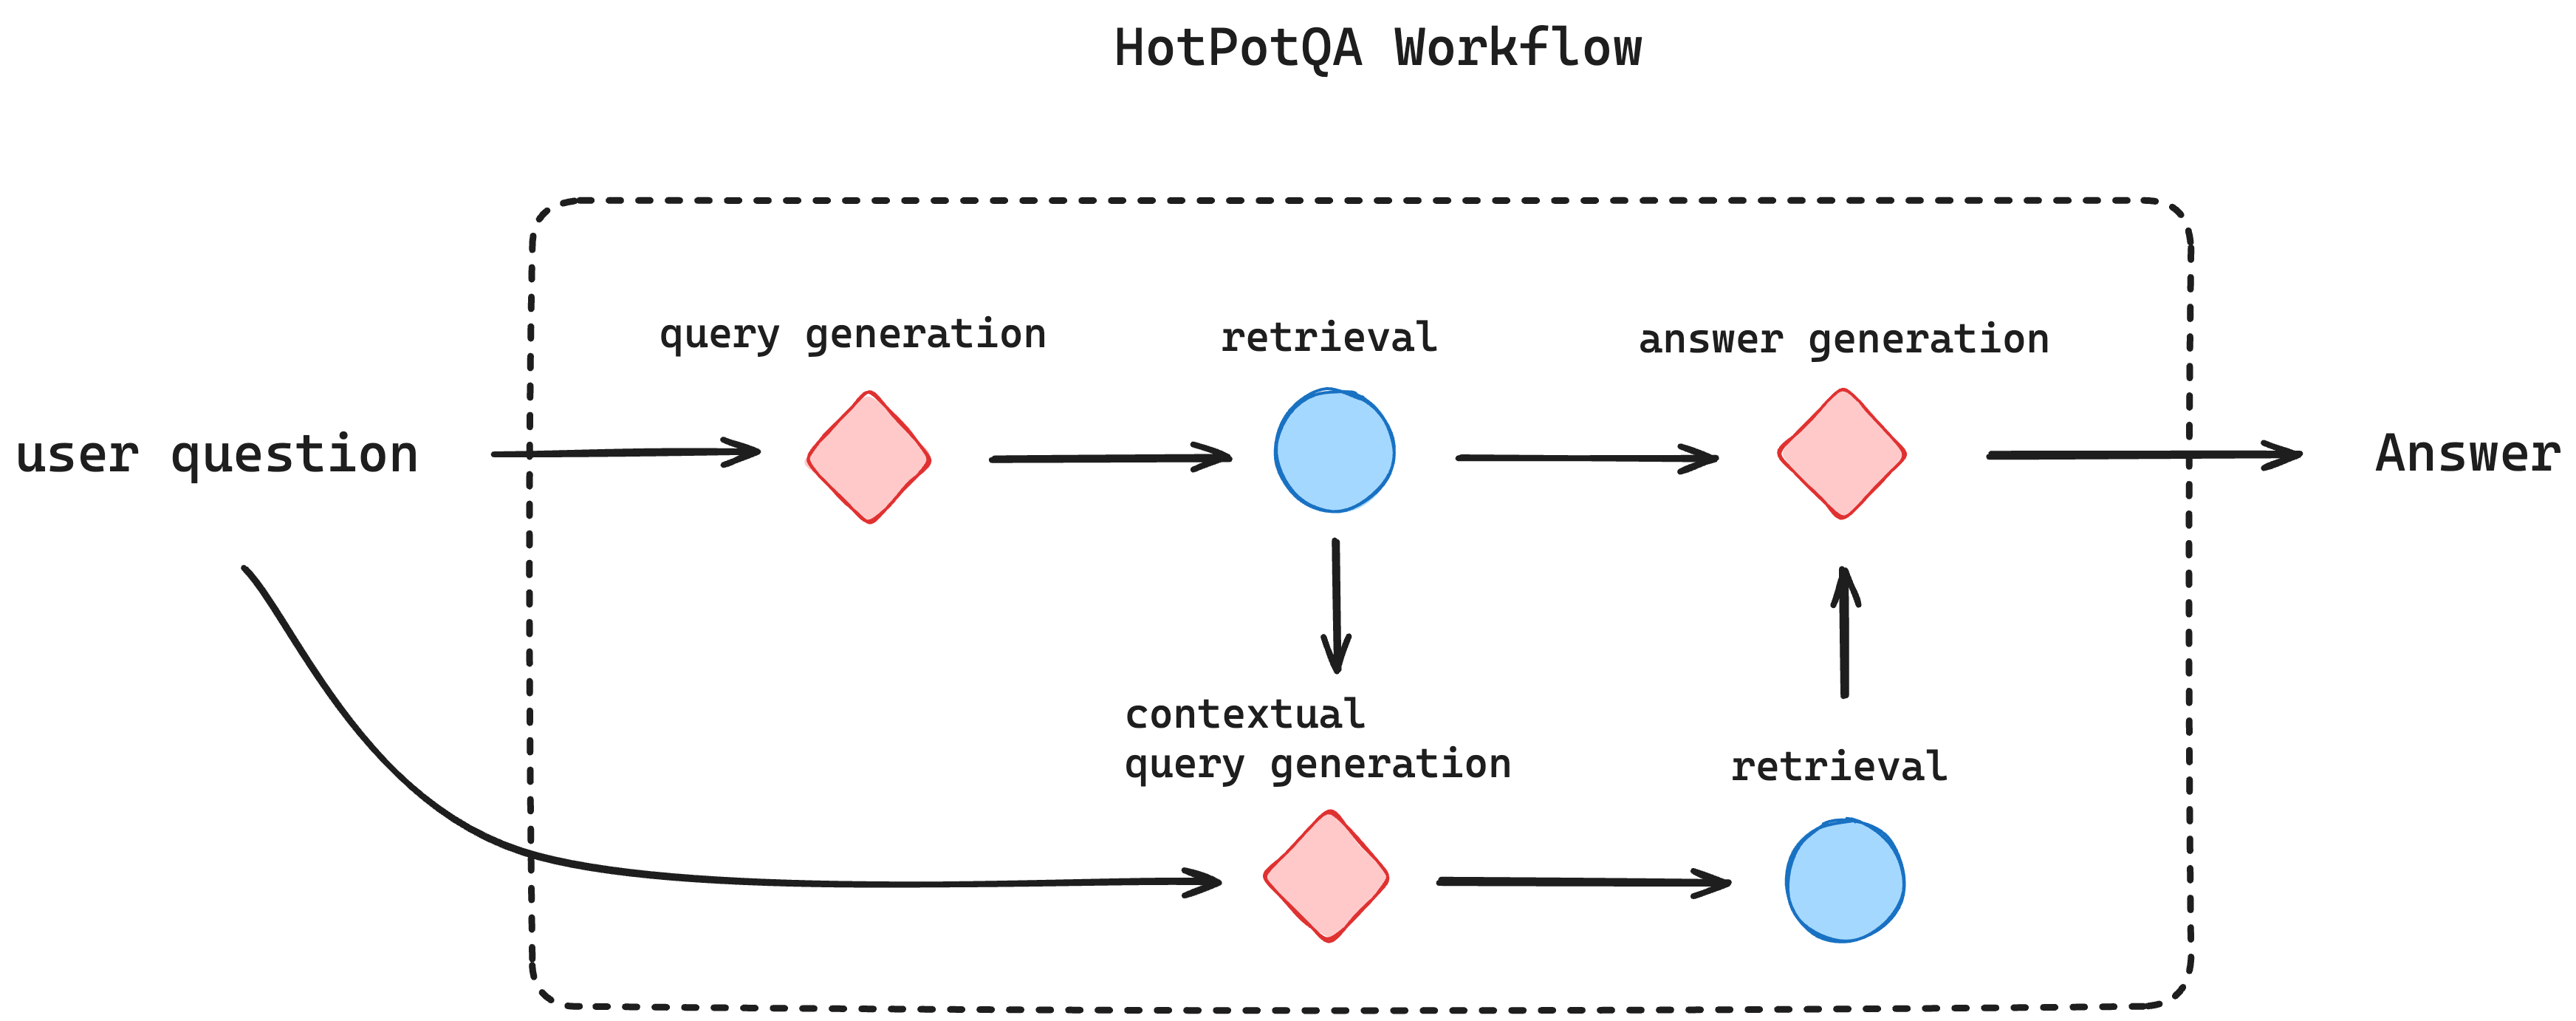

## 1) Setup

First, let's set the environment for workflow execution. Following keys are required:

OPENAI_API_KEY="your-openai-key"
COLBERT_URL="colbert-serving-url"

> **Note:** 
>
> If you are using DSPy's ColBERT service, try link `http://20.102.90.50:2017/wiki17_abstracts`. 
>
> For hosting on your local machine, check [ColBERT official repo](https://github.com/stanford-futuredata/ColBERT) for installation and setup.

## 2) Check HotPotQA Workflow

The complete code for this workflow is based on `dspy` and is avaibale in `workflow.py`. Try it out with:

In [1]:
%run workflow.py

{'answer': 'The 2010 population of Woodmere, New York, the birthplace of Gerard Piel, was 17,121.'}


## 3) Optimize The Workflow

The workflow entry point is already registered using annotation `cognify.register_opt_workflow`.

Here we configure the optimization pipeline:
1. Define the evaluation method
2. Define the data loader
3. Config the optimizer

### 3.1 Tell Cognify how good the answer is

We use builtin f1 score to evaluate the similarity between the predicted answer and the given ground truth.

In [2]:
import cognify

@cognify.register_opt_score_fn
def answer_f1(answer: str, ground_truth: str):
    return cognify.metric.f1_score_str(answer, ground_truth)

### 3.2 Tell Cognify what data to use

We directly use the hotpotqa dataset from DSPy with minor formatting change.

The loaded data should be a series of paris (input / ground_truth). 

Both input and ground_truth should be a dictionary or `None`.

Cognify will dispath the data by matching their name to the function signature, in short:

```python
# register workflow
# register evaluator

data: [(input, ground_truth), ...] = data_loader()
for input, ground_truth in data:
    result = workflow(**input)
    eval_inputs = as_per_func_signature(evaluator, input, result, ground_truth)
    score = evaluator(**eval_inputs)
```

According to the above rule, we register the data loader as follows:

In [3]:
def formatting(item):
    return (
        {'question': item.question},
        {'ground_truth': item.answer}
    )

@cognify.register_data_loader
def load_hotpotqa_data():
    from dspy.datasets.hotpotqa import HotPotQA
    dataset = HotPotQA(train_seed=1, train_size=150, eval_seed=2023, dev_size=200, test_size=0)
    
    trainset = [formatting(x) for x in dataset.train[0:100]]
    valset = [formatting(x) for x in dataset.train[100:150]]
    devset = [formatting(x) for x in dataset.dev]
    return trainset, valset, devset

### 3.3 Config the optimizer

Let's use the default configuration to optimize this workflow. The search space includes:
- 2 fewshot examples to add for each agent
- whether to apply Chain-of-thought to each agent

In [7]:
from cognify.hub.search import default

search_settings = default.create_search()

## 4 Start the Optimization

You can save the above configs in `config.py` file and use Cognify's CLI to fire the optimization with:

```console
$ cognify optimize workflow.py
```

Alternatively you can run the following:

In [ ]:
train, val, dev = load_hotpotqa_data()

opt_cost, pareto_frontier, opt_logs = cognify.optimize(
    script_path="workflow.py",
    control_param=search_settings,
    train_set=train,
    val_set=val,
    eval_fn=answer_f1,
    force=True, # This will overwrite the existing results
)